In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

In [ ]:
print("\nLOAD DỮ LIỆU")

df = pd.read_csv('../data/raw/jobs.csv')
print(f"Đã load dữ liệu: {df.shape[0]:,} dòng, {df.shape[1]} cột")

# Tạo bản sao để so sánh sau này
df_original = df.copy()
print(f"Đã tạo bản sao dữ liệu gốc")


LOAD DỮ LIỆU
Đã load dữ liệu: 85,470 dòng, 11 cột
Đã tạo bản sao dữ liệu gốc


# XỬ LÝ GIÁ TRỊ THIẾU

In [104]:
# Kiểm tra giá trị thiếu
missing_before = df.isnull().sum()
print("\nGiá trị thiếu trước xử lý:")
print(missing_before[missing_before > 0])


Giá trị thiếu trước xử lý:
job_title         7
city             32
skills        11294
job_fields     7625
dtype: int64


In [105]:
# Xử lý cột job_fields
print("\nXử lý cột job_fields:")
missing_fields = df['job_fields'].isnull().sum()
print(f"   - Số dòng thiếu job_fields: {missing_fields:,} ({missing_fields/len(df)*100:.2f}%)")

# Điền "Chưa phân loại" cho job_fields thiếu
df['job_fields'] = df['job_fields'].fillna('Chưa phân loại')
print("Đã điền 'Chưa phân loại' cho job_fields thiếu")


Xử lý cột job_fields:
   - Số dòng thiếu job_fields: 7,625 (8.92%)
Đã điền 'Chưa phân loại' cho job_fields thiếu


In [106]:
#Xử lý cột skills
print("\nXử lý cột skills:")
missing_skills = df['skills'].isnull().sum()
print(f"   - Số dòng thiếu skills: {missing_skills:,} ({missing_skills/len(df)*100:.2f}%)")

# Điền "Không yêu cầu" cho skills thiếu
df['skills'] = df['skills'].fillna('Không yêu cầu')
print("Đã điền 'Không yêu cầu' cho skills thiếu")


Xử lý cột skills:
   - Số dòng thiếu skills: 11,294 (13.21%)
Đã điền 'Không yêu cầu' cho skills thiếu


In [107]:
# job_title, city, position_level - nếu thiếu thì xóa dòng
essential_columns = ['job_title', 'city', 'position_level']
rows_before = len(df)
df = df.dropna(subset=essential_columns)
rows_dropped = rows_before - len(df)

if rows_dropped > 0:
    print(f"Đã xóa {rows_dropped:,} dòng thiếu thông tin quan trọng")
else:
    print("Không có dòng thiếu thông tin quan trọng")

Đã xóa 39 dòng thiếu thông tin quan trọng


In [108]:
# Kiểm tra lại giá trị thiếu
missing_after = df.isnull().sum()
print("\nGiá trị thiếu sau xử lý:")
print(missing_after[missing_after > 0])


Giá trị thiếu sau xử lý:
Series([], dtype: int64)


# CHUẨN HÓA DỮ LIỆU VĂN BẢN

In [109]:
# Loại bỏ khoảng trắng thừa
print("\nLoại bỏ khoảng trắng thừa:")
text_columns = ['job_title', 'job_type', 'position_level', 'city', 'experience', 'skills', 'job_fields', 'salary', 'unit']

for col in text_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip()
        df[col] = df[col].str.replace(r'\s+', ' ', regex=True)

print("Đã loại bỏ khoảng trắng thừa cho các cột văn bản")


Loại bỏ khoảng trắng thừa:
Đã loại bỏ khoảng trắng thừa cho các cột văn bản


In [110]:
# Chuẩn hóa chữ hoa/thường
print("\nChuẩn hóa chữ hoa/thường:")

# Viết hoa chữ cái đầu cột city
df['city'] = df['city'].str.title()
print("Đã chuẩn hóa cột 'city'")

# Viết hoa cột unit
df['unit'] = df['unit'].str.upper()
print("Đã chuẩn hóa cột 'unit'")


Chuẩn hóa chữ hoa/thường:
Đã chuẩn hóa cột 'city'
Đã chuẩn hóa cột 'unit'


In [111]:
# Chuẩn hóa chữ cột skills và job_fields
def clean_leading_comma(col):
    return (
        col
        .astype(str)
        .str.lstrip(', ')
        .str.strip()
    )

df['skills'] = clean_leading_comma(df['skills'])
df['job_fields'] = clean_leading_comma(df['job_fields'])
df[['skills', 'job_fields']].head()

,skills,job_fields
0,Không yêu cầu,"kinh doanh, bán hàng, nội ngoại thất, xây dựng"
1,"production planning staff, chuyên viên iso, th...","vận hành sản xuất, sản xuất, qc), quản lý chất..."
2,"trưởng phòng xây dựng, trưởng phòng đấu thầu, ...","điện, xây dựng, điện tử, điện lạnh, dầu khí, đ..."
3,Không yêu cầu,"dệt may, nghệ thuật, da giày, thiết kế, mỹ thu..."
4,Không yêu cầu,"tư vấn, bán sỉ, bán lẻ, kinh doanh, bán hàng"


# XỬ LÝ DỮ LIỆU KHÔNG NHẤT QUÁN

In [112]:
print("\nChuẩn hóa cột experience:")
print(f"   Các giá trị unique trước xử lý: {df['experience'].nunique()}")
print(f"   Top 10: {df['experience'].value_counts().head(71).to_dict()}")


Chuẩn hóa cột experience:
   Các giá trị unique trước xử lý: 181
   Top 10: {'không yêu cầu': 36044, '1 - 2 năm': 7188, 'trên 1 năm': 7035, 'trên 2 năm': 4203, '1 - 3 năm': 3161, '2 - 3 năm': 2947, '3 - 5 năm': 2936, '2 - 5 năm': 2931, 'dưới 1 năm': 2872, '1 - 5 năm': 2243, 'trên 3 năm': 2187, 'dưới 5 năm': 1605, 'trên 5 năm': 878, 'lên đến 1 năm': 796, 'trên 0.5 năm': 776, '0.5 - 1 năm': 484, '2 năm': 429, '1 năm': 416, '5 - 10 năm': 383, '3 - 4 năm': 344, 'dưới 2 năm': 342, '2 - 4 năm': 341, '1 - 1 năm': 333, 'chưa có kinh nghiệm': 281, 'không yêu cầu kinh nghiệm': 280, '5 - 7 năm': 264, '3 - 10 năm': 224, '3 năm': 217, '2 - 10 năm': 211, '4 - 5 năm': 191, 'trên 4 năm': 169, 'dưới 3 năm': 133, '1 - 10 năm': 130, '3 - 7 năm': 122, 'dưới 0.5 năm': 121, '5 - 8 năm': 89, 'lên đến 2 năm': 85, '1 - 4 năm': 84, '5 - 6 năm': 75, 'lên đến 3 năm': 73, 'trên 02 năm': 68, '5 - 15 năm': 67, 'trên 6 năm': 62, '2 - 7 năm': 61, '5 năm': 59, 'lên đến 5 năm': 57, 'trên 10 năm': 57, '0.5 - 5 năm': 55,

In [113]:
# Mapping các giá trị experience về dạng chuẩn
experience_mapping = {
    'không yêu cầu': 'Không yêu cầu',
    'khong yeu cau': 'Không yêu cầu',
    'chưa có kinh nghiệm': 'Không yêu cầu',
    'chua co kinh nghiem': 'Không yêu cầu',
    'lên đến 1 năm':'1-2 năm',
    'dưới 1 năm': 'Dưới 1 năm',
    'duoi 1 nam': 'Dưới 1 năm',
    'dưới 5 năm': '1-5 năm',
    'trên 0.5 năm':'Dưới 1 năm',
    '0.5 - 1 năm': 'Dưới 1 năm',
    'trên 1 năm': '1-2 năm',
    'tren 1 nam': '1-2 năm',
    'trên 2 năm': '2-3 năm',
    'tren 2 nam': '2-3 năm',
    'trên 02 năm': '2-3 năm',
    'trên 3 năm': '3-4 năm',
    'trên 5 năm': '5-6 năm',
    '1 năm': '1-2 năm',
    '2 năm': '2-5 năm',
    '3 năm': '2-5 năm',
    '4 năm': '2-5 năm',
    '5 năm': '2-5 năm',
    '1 - 2 năm': '1-2 năm',
    '1 - 3 năm': '1-3 năm',
    '2 - 5 năm': '2-5 năm',
    '2 - 3 năm': '2-3 năm',
    '3 - 4 năm': '3-4 năm',
    '3 - 5 năm': '3-5 năm',
    '1 - 5 năm': '1-5 năm',
    '5 - 10 năm': '5-10 năm',
    'trên 10 năm': 'Trên 10 năm',
    'tren 10 nam': 'Trên 10 năm',
    'dưới 2 năm': '1-2 năm', 
    '2 - 4 năm': '2-4 năm', 
    '1 - 1 năm': '1-2 năm', 
    'không yêu cầu kinh nghiệm': 'Không yêu cầu', 
    '5 - 7 năm': '5-7 năm', 
    '3 - 10 năm': '3-10 năm', 
    '2 - 10 năm': '2-10 năm', 
    '4 - 5 năm': '4-5 năm', 
    'trên 4 năm': '4-5 năm', 
    'dưới 3 năm': '1-3 năm', 
    '1 - 10 năm': '1-10 năm', 
    '3 - 7 năm': '3-7 năm', 
    'dưới 0.5 năm': 'Dưới 1 năm', 
    '5 - 8 năm': '5-8 năm',
    'lên đến 2 năm': '1-2 năm', 
    '1 - 4 năm': '1-4 năm', 
    '5 - 6 năm': '5-6 năm', 
    'lên đến 3 năm': '1-3 năm', 
    '5 - 15 năm': '5-15 năm', 
    'trên 6 năm': '6-7 năm', 
    '2 - 7 năm': '2-7 năm', 
    'lên đến 5 năm': '1-5 năm',  
    '0.5 - 5 năm': 'Dưới 1 năm', 
    '4 - 6 năm': '4-6 năm', 
    '2 - 2 năm': '2-5 năm', 
    '2 - 8 năm': '2-8 năm', 
    '0.5 - 2 năm': 'Dưới 1 năm', 
    '3 - 15 năm': '3-15 năm', 
    '3 - 8 năm': '3-8 năm', 
    '3 - 6 năm': '3-6 năm', 
    '2 - 15 năm': '2-15 năm', 
    'trên 7 năm': '7-8 năm', 
    '5 - 5 năm': '2-5 năm',
    '4 - 10 năm': '4-10 năm',
    'trên 01 năm': '1-2 năm',
    '1 - 7 năm': '1-7 năm',
    '2 - 6 năm': '2-6 năm',
    '5 - 20 năm': '5-20 năm',
    '0.5 - 3 năm': 'Dưới 1 năm',
    '8 - 10 năm': '8-10 năm',
    '7 - 10 năm': '7-10 năm',
    'trên 03 năm': '3-4 năm',
    '10 - 15 năm': 'Trên 10 năm',
    '1 - 8 năm': '1-8 năm', 
    '6 - 1 năm': '1-2 năm',
    'trên 2 năm - nhanh nhẹn, chịu khó học hỏi và tiếp thu. - độ tuổi: 25-35 tuổi.': '2-3 năm',
    '10 - 20 năm': 'Trên 10 năm',
    '1 - 15 năm': '1-15 năm',
    '3 - 9 năm': '3-9 năm',
    '4 - 7 năm': '4-7 năm',
    '3 - 20 năm': '3-20 năm',
    '12 - 1 năm': '1-2 năm', 
    '3 - 3 năm': '3-5 năm', 
    '8 - 15 năm': '8-15 năm', 
    '2 - 1 năm': '1-2 năm', 
    'lên đến 15 năm': '1-15 năm', 
    '4 - 8 năm': '4-8 năm', 
    'lên đến 4 năm': '1-4 năm',
    '2 - 20 năm': '2-20 năm',
    '4 - 15 năm': '4-15 năm', 
    'dưới 4 năm': '1-4',
    '01 - 3 năm': '1-3 năm',
    'lên đến 10 năm': '1-10 năm',
    '7 - 15 năm': '7-15 năm',
    '1 - 9 năm': '1-9 năm',
    '03 - 5 năm': '3-5 năm',
    '0 - 0 năm': 'Không yêu cầu',
    '1 - 6 năm': '1-6 năm',
    'dưới 10 năm': '1-10 năm',
    'trên 8 năm': '8-9 năm',
    '02 - 02 năm': '2-5 năm',
    '15 - 5 năm': '4-5 năm',
    '1 - 02 năm': '1-2 năm',
    '1 - 4 năm - có kinh nghiệm về ngành thẩm mỹ là một lợi thế - có khả năng xây dựng, quản trị cộng đồng cộng tác viên, affiliate. kỹ năng chuyên môn: - kỹ năng giao tiếp, thuyết trình tốt với các cấp độ trong công ty. - kỹ năng tự nghiên cứu, tìm hiểu kiến thức mới nhanh. - kỹ năng làm proposal, canva. - giao tiếp tiếng anh - có tư duy logic, khả năng phân tích và giải quyết vấn đề. độ tuổi: 26-30 giới tính: nữ, nam, lgbt - có ngoại hình': '1-4 năm',
    '10 - 3 năm': '1-3 năm', 
    '1 - 12 năm': '1-12 năm',
    '4 - 20 năm': '4-20 năm', 
    '1 - 2 năm · tốt nghiệp trung cấp, cao đẳng trở lên chuyên ngành thủy sản hoặc các ngành liên quan · ưu tiên kinh nghiệm làm phòng lab, rd': '1-2 năm', 
    '22 - 1 năm': '1-2 năm', 
    '30 - 3 năm': '1-3 năm',
    '02 - 6 năm': '2-6 năm', 
    '2 - 25 năm': '2-25 năm', 
    '6 - 8 năm': '6-8 năm', 
    '13 - 1 năm': '1-2 năm', 
    'dưới 8 năm': '1-8 năm',
    '5 - 2 năm': '2-5 năm',
    '3 - 1 năm': '1-2 năm', 
    '06 - 01 năm': '1-2 năm', 
    '35 - 01 năm': '1-2 năm', 
    '6 - 10 năm': '6-10 năm', 
    '5 - 25 năm': '5-25 năm', 
    'dưới 5 năm 3.ưu tiên có khả năng giao tiếp cơ bản bằng tiếng trung .': '1-5 năm', 
    '01 - 02 năm': '1-2 năm', 
    '27 - 03 năm': '1-3 năm', 
    '1 - 11 năm': '1-11 năm', 
    '25 - 1 năm': '1-2 năm', 
    '600 - 1 năm': '1-2 năm',
    '3 - 02 năm': '2-5 năm', 
    '02 - 03 năm': '2-3 năm',
    '03 - 05 năm': '3-5 năm', 
    '2 - 14 năm': '2-14 năm', 
    '02 - 5 năm': '2-5 năm', 
    'dưới 1 năm • ưu tiên ứng viên có kinh nghiệm trong ngành f&b. • kỹ năng giao tiếp, thuyết phục, phân tích và dự đoán tình hình tốt. • nhạy bén với thông tin mạng xã hội, bắt trend kịp thời. • không ngại ống kính, có thể host video,livestream. • chịu được áp lực công việc và sẵn sàng di chuyển,công tác. • năng động, chủ động học hỏi cái mới và có tinh thần trách nhiệm cao, cẩn thận trong công việc. • có máy tính cá nhân phục vụ công việc.': 'Dưới 1 năm', 
    '0.5 - 0.5 năm': 'Dưới 1 năm',
    '9 - 10 năm': '9-10 năm', 
    '365 - 2 năm': '1-2 năm', 
    '40 - 2 năm': '1-2 năm',
    '20 - 35 năm': 'Trên 10 năm', 
    '27 - 35 năm': 'Trên 10 năm', 
    '45 - 2 năm': '1-2 năm',
    '37 - 2 năm': '1-2 năm', 
    '01 - 03 năm': '1-3 năm',
    '3 - 4 năm - kỹ năng thực hành lâm sàng tốt, phản ứng nhanh trong các tình huống cấp cứu - khả năng làm việc độc lập và làm việc nhóm hiệu quả - tinh thần trách nhiệm cao, cẩn thận, tỉ mỉ trong công việc - khả năng giao tiếp tốt với đồng nghiệp và bệnh nhân - sẵn sàng trực đêm và làm việc ngoài giờ khi cần thiết': '3-4 năm',
    '25 - 3 năm': '1-3 năm', 
    '01 - 5 năm': '1-5 năm', 
    '7 - 20 năm': '7-20 năm', 
    '7 - 12 năm': '7-12 năm', 
    '1 - 3 năm yêu cầu học vấn, kỹ năng': '1-3 năm',
    '2 - 5 năm - quản lý đội nhóm, mạnh về tuyển dụng và đào tạo nhân sự - có tinh thần cầu tiến, chủ động trong công việc': '2-5 năm',
    '3 - 12 năm': '3-12 năm',
    'lên đến 7 năm': '1-7 năm',
    '25 - 35 năm': 'Trên 10 năm', 
    '06 - 1 năm': '1-2 năm',
    '8 - 1 năm': '1-2 năm', 
    '6 - 23 năm': '6-23 năm', 
    '5 - 18 năm': '5-18 năm', 
    '9 - 11 năm': '9-11 năm', 
    '3 - 30 năm': '3-30 năm', 
    '30 - 45 năm': 'Trên 10 năm', 
    '15 - 25 năm': 'Trên 10 năm', 
    'trên 15 năm': 'Trên 10 năm', 
    '7 - 9 năm': '7-9 năm', 
    '-1 - 0 năm': 'Không yêu cầu', 
    '8 - 12 năm': '8-12 năm', 
    '8 - 20 năm': '8-20 năm', 
    '10 - 30 năm': 'Trên 10 năm', 
    'trên 20 năm': 'Trên 10 năm', 
    'lên đến 6 năm': '1-6 năm', 
    '6 - 11 năm': '6-11 năm', 
    '5 - 12 năm': '5-12 năm', 
    '3 - 17 năm': '3-17 năm', 
    'error': 'Không yêu cầu', 
    '7 - 25 năm': '7-25 năm', 
    '40 - 50 năm': 'Trên 10 năm', 
    '1 - 20 năm': '1-20 năm', 
    '7 - 13 năm': '7-13 năm', 
    '4 - 9 năm': '4-9 năm', 
    'lên đến 8 năm': '1-8 năm', 
    '6 - 15 năm': '6-15 năm', 
    '4 - 12 năm': '4-12 năm', 
    '6 - 3 năm': '1-3 năm', 
    '30 - 2 năm': '1-2 năm', 
    '23 - 02 năm': '1-2 năm', 
    'trên 1 năm - đã từng làm ở công ty diễn họa có khách hàng là các chủ đầu tư lớn là một điểm cộng.': '1-2 năm', 
    '7 - 1 năm': '1-2 năm'
}

df['experience'] = df['experience'].str.lower().replace(experience_mapping)
print(f" Đã chuẩn hóa experience xuống {df['experience'].nunique()} giá trị unique")

 Đã chuẩn hóa experience xuống 79 giá trị unique


In [127]:
# Chuẩn hóa cột position_level
print("\nChuẩn hóa cột position_level:")
print(f"   Các giá trị unique: {df['position_level'].unique()}")


Chuẩn hóa cột position_level:
   Các giá trị unique: ['Nhân viên' 'Trưởng nhóm' 'Quản lý' 'Thực tập sinh' 'Giám đốc'
 'Phó giám đốc' 'Chưa cập nhật' 'Cộng tác viên' 'Chuyên gia'
 'Trưởng phòng']


In [115]:
position_mapping = {
    'nhan vien': 'Nhân viên',
    'nhân viên': 'Nhân viên',
    'truong nhom': 'Trưởng nhóm',
    'trưởng nhóm': 'Trưởng nhóm',
    'team leader': 'Trưởng nhóm',
    'quan ly': 'Quản lý',
    'quản lý': 'Quản lý',
    'giam doc': 'Giám đốc',
    'giám đốc': 'Giám đốc',
    'thuc tap sinh': 'Thực tập sinh',
    'thực tập sinh': 'Thực tập sinh',
    'intern': 'Thực tập sinh',
    'trưởng nhóm , giám sát': 'Trưởng nhóm',
    'phó giám đốc': 'Phó giám đốc',
    'mới tốt nghiệp': 'Thực tập sinh',
    'sinh viên, thực tập sinh': 'Thực tập sinh',
    'error': 'Chưa cập nhật',
    'tổng giám đốc': 'Tổng giám đốc',
    'chuyên viên, nhân viên':'Nhân viên',
    'quản lý cấp trung': 'Quản lý',
    'quản lý nhóm, giám sát':'Quản lý',
    'cộng tác viên': 'Cộng tác viên',
    'chuyên gia':'Chuyên gia',
    'quản lý cấp cao': 'Quản lý',
    '':'Chưa cập nhật',
    'chưa cập nhật':'Chưa cập nhật',
    'nhân viên, chuyên viên':'Nhân viên',
    'trưởng nhóm, trưởng phòng':'Trưởng phòng',
    'mới tốt nghiệp, thực tập sinh':'Thực tập sinh',
    'giám đốc và cấp cao hơn':'Giám đốc',
    'quản lý , giám sát':'Quản lý',
    'trưởng, phó phòng':'Trưởng phòng'
}

df['position_level'] = df['position_level'].str.lower().replace(position_mapping)
print(f"Đã chuẩn hóa position_level")

Đã chuẩn hóa position_level


In [116]:
print("\nChuẩn hóa cột unit:")
print(f"   Các giá trị unique: {df['unit'].unique()}")

# Chỉ giữ VND và USD
df = df[df['unit'].isin(['VND', 'USD'])]
print(f" Đã lọc chỉ giữ VND và USD")
print(f" Số dòng còn lại: {len(df):,}")


Chuẩn hóa cột unit:
   Các giá trị unique: ['VND' 'USD']
 Đã lọc chỉ giữ VND và USD
 Số dòng còn lại: 85,431


In [117]:
df.head()

,job_title,job_type,position_level,city,experience,skills,job_fields,salary,salary_min,salary_max,unit
0,trưởng phòng kinh doanh,nhân viên chính thức,Trưởng nhóm,Hồ Chí Minh,1-2 năm,Không yêu cầu,"kinh doanh, bán hàng, nội ngoại thất, xây dựng",15 tr - 50 tr vnd,15.0,50.0,VND
1,nhân viên qc ngành cơ khí,nhân viên chính thức,Nhân viên,Hồ Chí Minh,1-2 năm,"production planning staff, chuyên viên iso, th...","vận hành sản xuất, sản xuất, qc), quản lý chất...",8 tr - 11 tr vnd,8.0,11.0,VND
2,trưởng phòng đấu thầu,nhân viên chính thức,Trưởng nhóm,Hồ Chí Minh,5-7 năm,"trưởng phòng xây dựng, trưởng phòng đấu thầu, ...","điện, xây dựng, điện tử, điện lạnh, dầu khí, đ...",20 tr - 30 tr vnd,20.0,30.0,VND
3,home textile designer,nhân viên chính thức,Nhân viên,Hưng Yên,5-15 năm,Không yêu cầu,"dệt may, nghệ thuật, da giày, thiết kế, mỹ thu...","800 - 1,500 usd",20.0,37.5,USD
4,nhân viên kinh doanh,nhân viên chính thức,Nhân viên,Hồ Chí Minh,1-2 năm,Không yêu cầu,"tư vấn, bán sỉ, bán lẻ, kinh doanh, bán hàng",10 tr - 50 tr vnd,10.0,50.0,VND


In [ ]:
print("\nChuẩn hóa cột city:")
print(f"   Các giá trị unique trước xử lý: {df['city'].nunique()}")
print(f"   Top 10: {df['city'].value_counts().head(10).to_dict()}")


Chuẩn hóa cột city:
   Các giá trị unique trước xử lý: 82
   Top 10: {'Hà Nội': 24497, 'Hồ Chí Minh': 23912, 'Bình Dương': 3714, 'Đồng Nai': 2387, 'Long An': 1543, 'Hải Phòng': 1490, 'Đà Nẵng': 1208, 'Hưng Yên': 1038, 'Bắc Ninh': 982, 'Tây Ninh': 711, 'Cần Thơ': 643, 'Hải Dương': 612, 'Nghệ An': 543, 'Vũng Tàu': 521, 'Khánh Hòa': 505, 'Quảng Ninh': 497, 'Bắc Giang': 476, 'Hà Nam': 468, 'Kiên Giang': 445, 'Điện Biên': 425, 'Thái Bình': 417, 'Toàn Quốc': 412, 'An Giang': 394, 'Lâm Đồng': 393, 'Thanh Hóa': 337, 'Đắk Lắk': 336, 'Bình Phước': 333, 'Bà Rịa Vũng Tàu': 315, 'Nam Định': 311, 'Phú Thọ': 311, 'Tiền Giang': 307, 'Thái Nguyên': 293, 'Quảng Nam': 278, 'Thừa Thiên Huế': 264, 'Vĩnh Phúc': 261, 'Bến Tre': 260, 'Bình Thuận': 249, 'Bình Định': 217, 'Phú Yên': 216, 'Sóc Trăng': 210, 'Đồng Tháp': 207, 'Cà Mau': 207, 'Ninh Bình': 192, 'Quảng Ngãi': 185, 'Bạc Liêu': 183, 'Kon Tum': 169, 'Gia Lai': 164, 'Hà Tĩnh': 143, 'Hậu Giang': 140, 'Sơn La': 140, 'Hòa Bình': 131, 'Vĩnh Long': 130, 'Quản

In [119]:
city_mapping = {
    'Hà Hội': 'Hà Nội',
    'Đắk Lawsk': 'Đắk lắk',
    '20':'Thái Nguyên',
    'Biên Hòa': 'Đồng Nai', 
    'Thủ Dầu Một': 'Bình Dương',
    'Quận 1': 'Hồ Chí Minh',   
    'Nha Trang': 'Khánh Hòa', 
    'Ho Chi Minh City': 'Hồ Chí Minh', 
    'Cầu Giấy': 'Hà Nội',
    'Thủ Đức': 'Hồ Chí Minh',
    'Quận 12': 'Hồ Chí Minh',
    'Quận Tân Bình': 'Hồ Chí Minh',
    'Việt Nam': 'Toàn Quốc',
    'Tp Thủ Đức': 'Hồ Chí Minh',
    'Hải An': 'Hải Phòng',
    'Thanh Xuân': 'Hà Nội',
    'Tp Huế': 'Thừa Thiên Huế',
    'Phan Thiết': 'Bình Thuận', 
    'Quận 9': 'Hồ Chí Minh',
    'Long Biên': 'Hà Nội',
    'Quận 7': 'Hồ Chí Minh',
    'Vietnam': 'Toàn Quốc',
    'Bắc Từ Liêm': 'Hà Nội',
    'Số 74 Phạm Văn Đồng': 'Hồ Chí Minh',
    'Nam Từ Liêm': 'Hà Nội',
    'Hoàng Mai': 'Hà Nội',
    'Quận 3': 'Hồ Chí Minh', 
    'Quận Bình Tân': 'Hồ Chí Minh',
    'Quận Phú Nhuận': 'Hồ Chí Minh',
    'Hanoi': 'Hà Nội',
    'Huế': 'Thừa Thiên Huế',
    'Bình Tân': 'Hồ Chí Minh',
    'Dak Lak': 'Đắk Lắk',
    'Đống Đa': 'Hà Nội',
    'Toà Nhà Golden King Nguyễn Lương Bằng Quận 7': 'Hồ Chí Minh',
    'Hà Đông': 'Hà Nội',
    'Ba Đình': 'Hà Nội',
    'Quận 10': 'Hồ Chí Minh',
    'Quận Gò Vấp': 'Hồ Chí Minh',
    'Quận Hải Châu': 'Đà Nẵng', 
    'Toàn Tỉnh': 'Toàn Quốc',
    'Mỹ Tho': 'Tiền Giang',
    'Phú Nhuận': 'Hồ Chí Minh',
    'Tòa Nhà Mb 21 Cát Linh': 'Hồ Chí Minh', 
    'Quận 2': 'Hồ Chí Minh', 
    'Bình Thạnh': 'Hồ Chí Minh', 
    'Hiệp Bình Phước': 'Hồ Chí Minh', 
    'Hai Bà Trưng': 'Hà Nội',
    'Nhật Bản': 'Nước Ngoài', 
    'Ho Chi Minh': 'Hồ Chí Minh',
    'Toà Nhà Tng 54A Nguyễn Chí Thanh': 'Hồ Chí Minh', 
    'Thanh Hoá': 'Thanh Hóa',
    'Số 107 Phố Xuân QuỳNh Trung HòA': 'Hà Nội',
    'Bd': 'Toàn quốc',
    'Quốc Tế': 'Toàn quốc',
    'Bến Cát': 'Bình Dương',
    'Q Bình Thạnh': 'Hồ Chí Minh',
    'Dĩ An': 'Bình Dương',
    'Quận Hà Đông': 'Hà Nội',
    'Quận 5': 'Hồ Chí Minh', 
    'Duy Tiên': 'Hà Nam', 
    'Tân Bình': 'Hồ Chí Minh', 
    'Hóc Môn': 'Hồ Chí Minh', 
    'Cần Giuộc': 'Long An',
    'Huyện Bình Chánh': 'Hồ Chí Minh',
    'Quận 11': 'Hồ Chí Minh', 
    'Nhơn Trạch': 'Đồng Nai', 
    'Phường Cổ Nhuế 2': 'Hà Nội',
    'Qtân Bình': 'Hồ Chí Minh', 
    'Quận Bình Thạnh': 'Hồ Chí Minh', 
    'Nguyễn Xiển': 'Hà Nội', 
    'Dak Nông': 'Đắk Nông', 
    '2604 Quốc Lộ 1A Xã Bình Chánh': 'Hồ Chí Minh', 
    'Thanh Trì': 'Hà Nội', 
    'Quận Đống Đa': 'Hà Nội', 
    'Kcx Linh Trung 2': 'Hồ Chí Minh',
    'Tan Binh Dist': 'Hồ Chí Minh',
    'Huyện Củ Chi': 'Hồ Chí Minh', 
    'Thành Phố Thủ Đức': 'Hồ Chí Minh',
    'Quận Hoàng Mai': 'Hà Nội',  
    'Dist 1': 'Hồ Chí Minh',
    'Q2': 'Hồ Chí Minh', 
    'Q10': 'Hồ Chí Minh', 
    'Hoàn Kiếm': 'Hà Nội', 
    'Qbình Tân': 'Hồ Chí Minh', 
    'Quận 8': 'Hồ Chí Minh', 
    'Q12': 'Hồ Chí Minh',
    'Hải Châu': 'Hải Phòng', 
    'Số 5 Ngõ 70 Nguyễn Hoàng': 'Hà Nội', 
    'Các Văn Phòng Đại Diện Tại Các Quận': 'Hồ Chí Minh', 
    'Số 04 Lê Liễu': 'Hà Nội', 
    'Đức Hòa': 'Long An', 
    'Quận Bắc Từ Liêm': 'Hà Nội',
    'California Fitness Yoga': 'Hồ Chí Minh', 
    'Thủ ĐứC': 'Hồ Chí Minh', 
    'Huyện Phú Xuyên': 'Hà Nội', 
    'Dist 3': 'Hồ Chí Minh', 
    'Q Cầu Giấy': 'Hà Nội', 
    'Online': 'Toàn Quốc', 
    'Tân Phú': 'Hồ Chí Minh', 
    'Quận Tây Hồ': 'Hà Nội', 
    'Phường Bình Thuận': 'Hồ Chí Minh', 
    'Lotte Mall Tây Hồ': 'Hà Nội', 
    'Thuận Thành': 'Bắc Ninh', 
    'Toàn Khu Vực': 'Toàn Quốc', 
    'Huyện Yên Mỹ': 'Hưng Yên', 
    'Hội An': 'Quảng Nam', 
    'BắC Ninh': 'Bắc Ninh', 
    'Cai Lậy': 'Tiền Giang', 
    'Quận Thanh Xuân': 'Hà Nội', 
    'Quận Tân Phú': 'Hồ Chí Minh', 
    '252 Hạ Hội Tân Lậpmiền Bắc': 'Hà Nội', 
    'Q3': 'Hồ Chí Minh', 
    'Toà Nhà Tng 54A Nguyễn Chí Than': 'Hồ Chí Minh', 
    'Pphú Lợi': 'Bình Dương', 
    'Kcn Amata': 'Toàn Quốc',
    'Hà Huy Giáp': 'Hồ Chí Minh', 
    '69B Thụy Khuê': 'Hà Nội', 
    'Tp Thủ Đức Bên Cạnh Trường Mầm Non Kcnc Quận 9': 'Hồ Chí Minh', 
    'Thuận An': 'Bình Dương', 
    'Thành Phố Quy Nhơn': 'Bình Định', 
    'Khu Đô Thị An Phú An Khánh': 'Hồ Chí Minh', 
    'Quận 4': 'Hồ Chí Minh', 
    'Tp Bến Cát': 'Bình Dương',
    'Văn Lâm': 'Hưng Yên',
    'Tại Nhà': 'Toàn Quốc',
    'Cổ Nhuế Gần Mega Market Phạm Văn Đồng': 'Hồ Chí Minh',
    'Gò Vấp': 'Hồ Chí Minh', 
    'Cờ Đỏ': 'Cần Thơ', 
    'Hòa Thành': 'Tây Ninh', 
    'Tân Uyên': 'Bình Dương',
    'Tỉnh Đaklak': 'Đắk lắk', 
    'Long Thành': 'Đồng Nai', 
    'Trảng Bàng': 'Tây Ninh', 
    'Fpt Shop Thành Phố Vĩnh Long': 'Vĩnh Long',
    'Kim Động': 'Hưng Yên', 
    'Đường Số 4': 'Hồ Chí Minh', 
    'Tpthủ Đức': 'Hồ Chí Minh', 
    'Lotte Tây Hồvincom Bà Triệutttm The Gardensavico Long Biên': 'Hà Nội',
    'Tỉnh Lào Cai': 'Lào Cai', 
    'Tòa Chung Cư Ban Cơ Yếu Chính Phủ': 'Hồ Chí Minh', 
    'Phú Lương': 'Thái Nguyên',
    'Hậu Lộc': 'Thanh Hóa', 
    'Phú Vang': 'Thừa Thiên Huế', 
    'Thành Phố Phú Quốc': 'Phú Quốc', 
    'Tất Cả Các Quậnhuyện': 'Hồ Chí Minh', 
    'Quận Hai Bà Trưng': 'Hà Nội', 
    'Hoài Đức': 'Hà Nội', 
    'Tp Buôn Ma Thuột': 'Đắk Lắk', 
    'P Hiệp Bình Phước': 'Hồ Chí Minh',
    'Q4': 'Hồ Chí Minh', 
    'Kcn Long Đức': 'Hồ Chí Minh', 
    'Tất Cả Các Huyện': 'Toàn Quốc', 
    'Phú Xuyên': 'Hà Nội', 
    'Phường Dịch Vọng Hậu': 'Hà Nội', 
    'Các Công Trình Xây Dựng Miền Bắc': 'Miền Bắc', 
    'Viet Nam': 'Toàn Quốc', 
    'Tp Hai Phong': 'Hải Phòng', 
    'Huyện Thống Nhất': 'Hà Nội', 
    'Qtân Phú': 'Hồ Chí Minh', 
    'Phường Tân Chánh Hiệp': 'Hồ Chí Minh',
    'Tp Long Khánh': 'Đồng Nai',
    'Hòa Cường': 'Đà Nẵng',
    'Q1': 'Hồ Chí Minh', 
    'Dự Án Quận Tây Hồ': 'Hà Nội', 
    'Kiến An': 'Bình Dương', 
    'Phường Hiệp Bình Phước': 'Hồ Chí Minh', 
    'Bình Xuyên': 'Vĩnh Phúc', 
    'Tp Dĩ An': 'Bình Dương', 
    'Tp Bmt': 'Đắk Lắk', 
    '161 Võ Nguyễn Giáp': 'Hồ Chí Minh', 
    'Lào Cai 3 Nơi Khác': 'Lào Cai',
    'Kcn Nhơn Trạch 3': 'Đồng Nai', 
    'Ưu Tiên Khu Vực Ứng Viên Sinh Sống': 'Toàn Quốc',
    '169 Nguyễn Ngọc Vũ': 'Hồ Chí Minh',
    'Cổ Nhuế 2': 'Hà Nội', 
    'Bn': 'Toàn Quốc', 
    'Dong Nai Province': 'Đồng Nai',
    'Vpbank Ứng Hòa': 'Hà Nội', 
    'Đức Hoà': 'Long An',
    'Kcn Quang Minh Mê Linh': 'Hồ Chí Minh', 
    'Liên Chiểu': 'Đà Nẵng', 
    'Thành Phố Long Khánh': 'Đồng Nai', 
    'Tây Hồ': 'Hà Nội', 
    '91 Nguyễn Chí Thanh': 'Hồ Chí Minh', 
    'Tất Cả Các Quận Huyện': 'Toàn Quốc', 
    'Hải Hà': 'Quảng Ninh', 
    'Tp Phủ Lý': 'Hải Nam', 
    '41 Thép Mới': 'Hồ Chí Minh', 
    'Bình Tân Khu Tên Lửa': 'Hồ Chí Minh', 
    'Da Nang': 'Đà Nẵng', 
    'Kv Đông Nam Bộ': 'Miền Nam', 
    'Hớn Quản': 'Bình Phước', 
    'Ha Noi': 'Hà Nội', 
    'Lai Vung': 'Đồng Tháp', 
    'Thu Duc City': 'Hồ Chí Minh', 
    'Không Phải Đến Công Ty': 'Toàn quốc', 
    'Hung Yen Province': 'Hưng Yên', 
    'Thành Phố Dĩ An': 'Bình Dương', 
    'Từ Liêm': 'Hà Nội', 
    'Fpt Shop Tp Rạch Giá': 'Kiên Giang', 
    'Phường Cổ Nhuế 1': 'Hà Nội', 
    'Q7': 'Hồ Chí Minh', 
    'Quận Cầu Giấy': 'Hà Nội', 
    'Gò Công Tây': 'Tiền Giang', 
    '8C Vũ Thạnh': 'Hà Nội', 
    'Q Bình Tân Đối Diện Cn1 Trong Kcn Tân Bình': 'Hồ Chí Minh', 
    '505 Minh Khai': 'Hồ Chí Minh', 
    'Tp Gò Công': 'Tiền Giang', 
    'Q 12': 'Hồ Chí Minh',
    'Kiến Tường': 'Long An', 
    'Kcn Vsip Ii': 'Toàn Quốc', 
    'Gò Dầu': 'Tây Ninh', 
    'Đại Lộ Thăng Long': 'Hà Nội', 
    'Trung Hòa': 'Hà Nội', 
    'Phường Khuê Trung': 'Đà Nẵng',
    'Buôn Ma Thuột': 'Đắk Lắk',
    'Thành Phố Hoà Bình': 'Hòa Bình', 
    'Huyện Văn Lâm': 'Hưng Yên', 
    'Minh Đức Cách Cầu Vượt Quán Giỏi 100 M': 'Hồ Chí Minh', 
    'Quận Ba Đình': 'Hà Nội', 
    '235 Nguyễn Trãi': 'Hồ Chí Minh', 
    'Từ Sơn': 'Bắc Ninh', 
    'Tx Dĩ An': 'Bình Dương', 
    'Q Hải Châu': 'Hải Phòng',  
    'Châu Thành': 'An Giang', 
    'Tòa Nhà Hòa Bình Green City': 'Hồ Chí Minh', 
    'Đông Hải 2': 'Bạc Liêu', 
    'Quận 6': 'Hồ Chí Minh', 
    'Tỉnh Hòa Bình': 'Hòa Bình', 
    'Khu Đt Hc': 'Hồ Chí Minh', 
    'Huyện Gia Lâm': 'Hà Nội', 
    'Kiên Thành': 'Bắc Giang', 
    'Q Tân Phú': 'Hồ Chí Minh', 
    'Quận Hoàn Kiếm': 'Hà Nội', 
    'Tràng Bảng': 'Tây Ninh', 
    'Nam Sơn': 'Bắc Ninh', 
    'Hà Đông': 'Hà Nội', 
    'Phường Hiệp Ninh': 'Tây Ninh',
    'Kcn Vsip 2': 'Toàn Quốc', 
    'Công Viên Phần Mềm Quang Trung': 'Hồ Chí Minh',
    'Tân Châu': 'An Giang',
    'Tp Sông Công': 'Thái Nguyên',
    'Hokkaido': 'Nước Ngoài',
    'Bình Thuận Bình Thuận': 'Bình Thuận',
    'Rạch Sỏi Rạch Giá': 'Kiên Giang', 
    'Tỉnh Tt Huế': 'Thừa Thiên Huế', 
    'Dầu Tiếng': 'Bình Dương', 
    'Đak Lak': 'Đắk Lawsk', 
    'Phường Minh Đức': 'Đồng Nai',
    'Phường Cầu Kho': 'Hồ Chí Minh',
    '68 Nguyễn Huệ': 'Hồ Chí Minh', 
    'Văn Phòng Công Ty Cổ Phần Tập Đoàn Xd Hoà Bình': 'Hồ Chí Minh', 
    'An Dương': 'Hải Phòng', 
    'Khu Vực Miền Bắc': 'Miền Bắc', 
    'Tòa Nhà Trung Yên 1 Số 1A Vũ Phạm Hàm Cầu Giấy': 'Hà Nội', 
    'Phiệp Bình Phước': 'Hồ Chí Minh', 
    'Tp Quy Nhơn': 'Bình Định', 
    'Miền Nam 3 Nơi Khác': 'Miền Nam',
    'Kcn Thăng Long': 'Hà Nội',
    'Q Phú Nhuận': 'Hồ Chí Minh',
    'Đà Lạt': 'Lâm Đồng',
    'Quận Hải An': 'Hải Phòng', 
    '31 Võ Văn Vân': 'Hồ Chí Minh', 
    'Qbình Thạnh': 'Hồ Chí Minh',
    'Số 35 Lê Văn Lương': 'Hồ Chí Minh', 
    'Kcn Ninh Hiệp': 'Hà Nội',
    'Tỉnh Tiền Giang': 'Tiền Giang', 
    'Hà Nộ': 'Hà Nội', 
    'Tp Lào Cai': 'Lào Cai', 
    'Đông Hưng Thuận': 'Hồ Chí Minh', 
    'Vĩnh Thạnh': 'Bình Định',
    'Tỉnh Lộ 43 Thủ Đức Hướng Cầu Gò Dưa': 'Hồ Chí Minh',
    'Fpt Shop Tháp Mười': 'Hồ Chí Minh',
    'Đường Thủ Khoa Huân – P Thành Nhất – Tp Buôn Ma Thuột': 'Đắk Lắk', 
    'Phú Tân': 'Hồ Chí Minh', 
    'Cổ Nhuế': 'Hà Nội',
    'Quận Thủ Đức': 'Hồ Chí Minh',
    'Thanh Oai': 'Hà Nội', 
    'Thanh Hoá Tp Thanh Hoá': 'Thanh Hóa',
    'Ba Gps': 'Hồ Chí Minh',
    'Huyện Đức Hòa': 'Long An', 
    'Yokohama': 'Nước Ngoài', 
    'Tpquy Nhơn': 'Bình Định', 
    'Hải Tân': 'Hải Dương', 
    'Bàu Bàng': 'Bình Dương', 
    'Hòa Vang': 'Đà Nẵng', 
    'Cẩm Phả': 'Quảng Ninh', 
    'Fpt Shop Vĩnh Thuận': 'Kiên Giang', 
    'Hoàng Kiếm': 'Hà Nội',
    'Ngô Quyền': 'Hồ Chí Minh', 
    'Phường Võ Thị Sáu': 'Hồ Chí Minh', 
    '44 Hoàng Sĩ Khải Phường 14 Quận 8': 'Hồ Chí Minh', 
    'Phú Giáo': 'Bình Dương', 
    'Tỉnh Quảng Trị': 'Quảng Trị', 
    'Cổ Nhuế 1': 'Hà Nội', 
    'Bắc Từ Liêm Đối Diện Công Viên Hòa Bình': 'Hà Nội', 
    'Huyện Bình Giang': 'Hải Dương', 
    'Tân Phước': 'Tiền Giang', 
    'Phường An Thới': 'Kiên Giang', 
    'Kcx Linh Trung 1': 'Hồ Chí Minh', 
    'Kcn Phú Mỹ 3': 'Vũng Tàu', 
    'Khác': 'Toàn Quốc', 
    'Kv Nam Trung Bộ': 'Miền Nam', 
    'Khu Ngoại Giao Đoàn': 'Toàn Quốc', 
    'Bình Thọ': 'Hồ Chí Minh', 
    'Phúc Yên': 'Vĩnh Phúc', 
    'Fpt Shop Tp Cao Lãnh': 'Đồng Tháp', 
    'Đại Kim': 'Hà Tĩnh', 
    'Đồng Xoài': 'Bình Phước', 
    'Kcn Quế': 'Bắc Ninh', 
    'Huyện Mê Linh': 'Hà Nội', 
    'Thị Xã Bến Cát': 'Bình Dương', 
    'Lệ Thủy': 'Quản Bình', 
    'Thành Phố Đài Bắc': 'Nước Ngoài', 
    'Fpt Shop Thị Xã Giá Rai': 'Bạc Liêu', 
    'P Cổ Nhuế 2': 'Hà Nội',
    'Phương Liệt': 'Hà Nội',
    'Phường Tân Đông Hiệp': 'Bình Dương', 
    'Quận Ninh Kiều': 'Cân Thơ', 
    '159 Quốc Lộ 1K': 'Hồ Chí Minh', 
    'The Golden Palm 21 Lê Văn Lương': 'Hồ Chí Minh', 
    'Tây Nam Linh Đàm': 'Hà Nội', 
    'Phường 4': 'Hà Nội', 
    'P Thạnh Mỹ Lợi': 'Hồ Chí Minh', 
    'Vị Thanh': 'Hậu Giang', 
    'P Hòa Thạnh': 'Tây Ninh', 
    'Phường Trung Liệt': 'Hà Nội', 
    'Việt Trì': 'Phú Thọ', 
    'Tp Vinh': 'Nghệ An', 
    'Thái Lan': 'Nước Ngoài', 
    'Quận Bình Tân Khu Tên Lửa': 'Hồ Chí Minh', 
    'Bình Long': 'Bình Phước',
    'Phường 17': 'Hồ Chí Minh', 
    'Phường 26': 'Hồ Chí Minh', 
    'Cửa Hàng Keira Tống 97 Phố Huế':'Thừa Thiên Huế', 
    'Công Ty Cổ Phần Xnk Tập Đoàn Nông Sản Việt Nam': 'Hồ Chí Minh', 
    '830000': 'Bình Phước', 
    'Bình Phước Bình Phước Bình Phước Bình Phước Bình Phước': 'Bình Phước',
    'Online Tại Nhà': 'Toàn Quốc',
    'Fpt Shop Huyện Châu Thành': 'An Giang',
    'Chơn Thành': 'Bình Phước',
    'P 22': 'Hồ Chí Minh', 
    'District 9': 'Hồ Chí Minh',
    'Tp Việt Trì': 'Phú Thọ', 
    'Dak Lak Dak Nông': 'Đắk Lắk',
    'Kcx Sai Gon Linh Trung 1': 'Hồ Chí Minh',
    'Kim Mã': 'Hà Nội',
    'Malaysia': 'Nước Ngoài',
    'Lộc Ninh': 'Bình Phước',
    'Tiền Giang Tiền Giang Tiền Giang Tiền Giang Tiền Giang': 'Tiền Giang',
    'Tokyo': 'Nước Ngoài',
    'Qphú Nhuận': 'Hồ Chí Minh',
    'Miền Nam 2 Nơi Khác': 'Miền Nam',
    '879 Quốc Lộ 13 Hiệp Bình Phước Thủ Đức': 'Hồ Chí Minh',
    'Phường An Lạc': 'Hồ Chí Minh',
    'Công Ty Thành Thành Công 158 Hồ Bá Kiện Phường 15 Quận 10': 'Hồ Chí Minh',
    'QuậN 1': 'Hồ Chí Minh', 
    'Times City': 'Hồ Chí Minh', 
    'Tp Hồ Chí Minh': 'Hồ Chí Minh', 
    'Fpt Shop Trần Văn Thời': 'Hồ Chí Minh', 
    'Bình Phước Bình Phước': 'Bình Phước',
    '52 Dien Bien Phu Street': 'Hồ Chí Minh', 
    '54A Nguyễn Chí Thanh': 'Hồ Chí Minh', 
    'Attapeu': 'Hồ Chí Minh', 
    'Bình Phước B': 'Bình Phước', 
    'Củ Chi': 'Hồ Chí Minh',
    'Kratie': 'Nước Ngoài',
    'Hòa Bình Bắc Cạn': 'Bắc Cạn',
    'Champasak': 'Nước Ngoài', 
    'Công Ty Tnhh Iljin Display Vina': 'Hồ Chí Minh',
    'Lào Cai 6 Nơi Khác': 'Lào Cai',
    '647 Quang Trung Phường 11 Quận Gò Vấp': 'Hồ Chí Minh',
    'Miền Nam 4 Nơi Khác': 'Miền Nam', 
    'Đồng Bằng Sông Cửu Long': 'Hà Nội',
    'Kampong Speu': 'Nước Ngoài',
    'Bangkok': 'Nước Ngoài',
    'Kv Bắc Trung Bộ Kv Nam Trung Bộ Đồng Bằng Sông Cửu Long': 'Hà Nội',
    'Lào Cai Hòa Bình': 'Lào Cai',
    'Gò VấP': 'Hồ Chí Minh',
    'Phường 13 Quận 10': 'Hồ Chí Minh',
    'Trung Văn': 'Hà Nội',
    'Phước Long': 'Bình Phước', 
    'Lô Cn5A Cụm Công Nghiệp Gia Lập Xã Gia Lập Huyện Gia Viễn': 'Ninh Bình', 
    'Kcn Sóng Thần 1': 'Bình Dương',
    'Kv Tây Nguyên': 'Tây Nguyên',
    'Đồng Bằng Sông Hồng': 'Hà Nội',
    'Thanh Hoá 2 Nơi Khác': 'Thanh Hóa',
    'Tuân Nguyễnnguyn': 'Hà Nội',
    'Phường 19': 'Hồ Chí Minh', 
    'Japan': 'Nước Ngoài',
    'Vpbank Cn Ba Đình': 'Hà Nội'
}

df['city'] = df['city'].replace(city_mapping)
print(f" Đã chuẩn hóa city xuống {df['city'].nunique()} giá trị unique")

 Đã chuẩn hóa city xuống 82 giá trị unique


# XỬ LÝ OUTLIERS (NGOẠI LAI)

In [120]:
# Xử lý outliers cho salary_min, salary_max
print("\nXử lý outliers cho lương:")

def remove_outliers_iqr(df, column, factor=1.5):
    """Loại bỏ outliers bằng phương pháp IQR"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    before = len(df)
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    after = len(df_filtered)
    removed = before - after
    
    print(f"   {column}:")
    print(f"      - Q1: {Q1:,.0f}, Q3: {Q3:,.0f}, IQR: {IQR:,.0f}")
    print(f"      - Giới hạn: [{lower_bound:,.0f}, {upper_bound:,.0f}]")
    print(f"      - Đã loại bỏ: {removed:,} dòng ({removed/before*100:.2f}%)")
    
    return df_filtered

# Xử lý outliers cho salary_min
if 'salary_min' in df.columns:
    df_temp = df[df['salary_min'].notna()]
    print(f"\n   Xử lý salary_min (có {len(df_temp):,} giá trị):")
    df = remove_outliers_iqr(df, 'salary_min', factor=3.0)

# Xử lý outliers cho salary_max
if 'salary_max' in df.columns:
    df_temp = df[df['salary_max'].notna()]
    print(f"\n   Xử lý salary_max (có {len(df_temp):,} giá trị):")
    df = remove_outliers_iqr(df, 'salary_max', factor=3.0)

print(f"\n Số dòng còn lại sau xử lý outliers: {len(df):,}")


Xử lý outliers cho lương:

   Xử lý salary_min (có 85,431 giá trị):
   salary_min:
      - Q1: 8, Q3: 15, IQR: 7
      - Giới hạn: [-13, 36]
      - Đã loại bỏ: 1,017 dòng (1.19%)

   Xử lý salary_max (có 84,414 giá trị):
   salary_max:
      - Q1: 12, Q3: 20, IQR: 8
      - Giới hạn: [-12, 44]
      - Đã loại bỏ: 3,150 dòng (3.73%)

 Số dòng còn lại sau xử lý outliers: 81,264


# XỬ LÝ DỮ LIỆU KHÔNG HỢP LỆ

In [121]:
# Kiểm tra salary_min <= salary_max
print("\nKiểm tra salary_min <= salary_max:")
invalid_salary = df[df['salary_min'] > df['salary_max']]
print(f"   - Số dòng có salary_min > salary_max: {len(invalid_salary):,}")

if len(invalid_salary) > 0:
    # Hoán đổi giá trị
    df.loc[df['salary_min'] > df['salary_max'], ['salary_min', 'salary_max']] = \
        df.loc[df['salary_min'] > df['salary_max'], ['salary_max', 'salary_min']].values
    print("  Đã hoán đổi salary_min và salary_max cho các dòng không hợp lệ")


Kiểm tra salary_min <= salary_max:
   - Số dòng có salary_min > salary_max: 3,273
  Đã hoán đổi salary_min và salary_max cho các dòng không hợp lệ


In [122]:
# Loại bỏ dòng có lương = 0 hoặc âm
print("\nLoại bỏ dòng có lương không hợp lệ:")
invalid_rows = len(df[(df['salary_min'] <= 0) | (df['salary_max'] <= 0)])
print(f"   - Số dòng có lương <= 0: {invalid_rows:,}")

if invalid_rows > 0:
    df = df[(df['salary_min'] > 0) & (df['salary_max'] > 0)]
    print(f" Đã loại bỏ {invalid_rows:,} dòng có lương không hợp lệ")


Loại bỏ dòng có lương không hợp lệ:
   - Số dòng có lương <= 0: 5,366
 Đã loại bỏ 5,366 dòng có lương không hợp lệ


# KIỂM TRA CHẤT LƯỢNG DỮ LIỆU SAU XỬ LÝ

In [123]:
print("\nTổng quan:")
print(f"   - Số dòng ban đầu: {len(df_original):,}")
print(f"   - Số dòng sau xử lý: {len(df):,}")
print(f"   - Số dòng đã xóa: {len(df_original) - len(df):,} ({(len(df_original) - len(df))/len(df_original)*100:.2f}%)")

print("\nGiá trị thiếu sau xử lý:")
missing_final = df.isnull().sum()
if missing_final.sum() > 0:
    print(missing_final[missing_final > 0])
else:
    print("   Không còn giá trị thiếu (ngoài salary_min/max)")

print("\nGiá trị trùng lặp sau xử lý:")
duplicates_final = df.duplicated().sum()
print(f"   - Số dòng trùng lặp: {duplicates_final:,}")

print("\nPhân bố các biến phân loại:")
categorical_cols = ['city', 'position_level', 'experience', 'unit']
for col in categorical_cols:
    print(f"\n   {col}: {df[col].nunique()} giá trị unique")
    print(f"   Top 5: {df[col].value_counts().head(10).to_dict()}")


Tổng quan:
   - Số dòng ban đầu: 85,470
   - Số dòng sau xử lý: 75,898
   - Số dòng đã xóa: 9,572 (11.20%)

Giá trị thiếu sau xử lý:
   Không còn giá trị thiếu (ngoài salary_min/max)

Giá trị trùng lặp sau xử lý:
   - Số dòng trùng lặp: 35,628

Phân bố các biến phân loại:

   city: 82 giá trị unique
   Top 5: {'Hà Nội': 24497, 'Hồ Chí Minh': 23912, 'Bình Dương': 3714, 'Đồng Nai': 2387, 'Long An': 1543, 'Hải Phòng': 1490, 'Đà Nẵng': 1208, 'Hưng Yên': 1038, 'Bắc Ninh': 982, 'Tây Ninh': 711}

   position_level: 10 giá trị unique
   Top 5: {'Nhân viên': 65008, 'Quản lý': 3316, 'Trưởng phòng': 2819, 'Trưởng nhóm': 2504, 'Thực tập sinh': 1669, 'Cộng tác viên': 237, 'Giám đốc': 206, 'Chuyên gia': 100, 'Phó giám đốc': 34, 'Chưa cập nhật': 5}

   experience: 71 giá trị unique
   Top 5: {'Không yêu cầu': 33540, '1-2 năm': 14873, '2-3 năm': 6371, 'Dưới 1 năm': 3935, '2-5 năm': 3193, '1-3 năm': 3154, '1-5 năm': 3000, '3-5 năm': 2520, '3-4 năm': 2122, '5-6 năm': 667}

   unit: 2 giá trị unique
   

# VISUALIZATION SO SÁNH TRƯỚC VÀ SAU

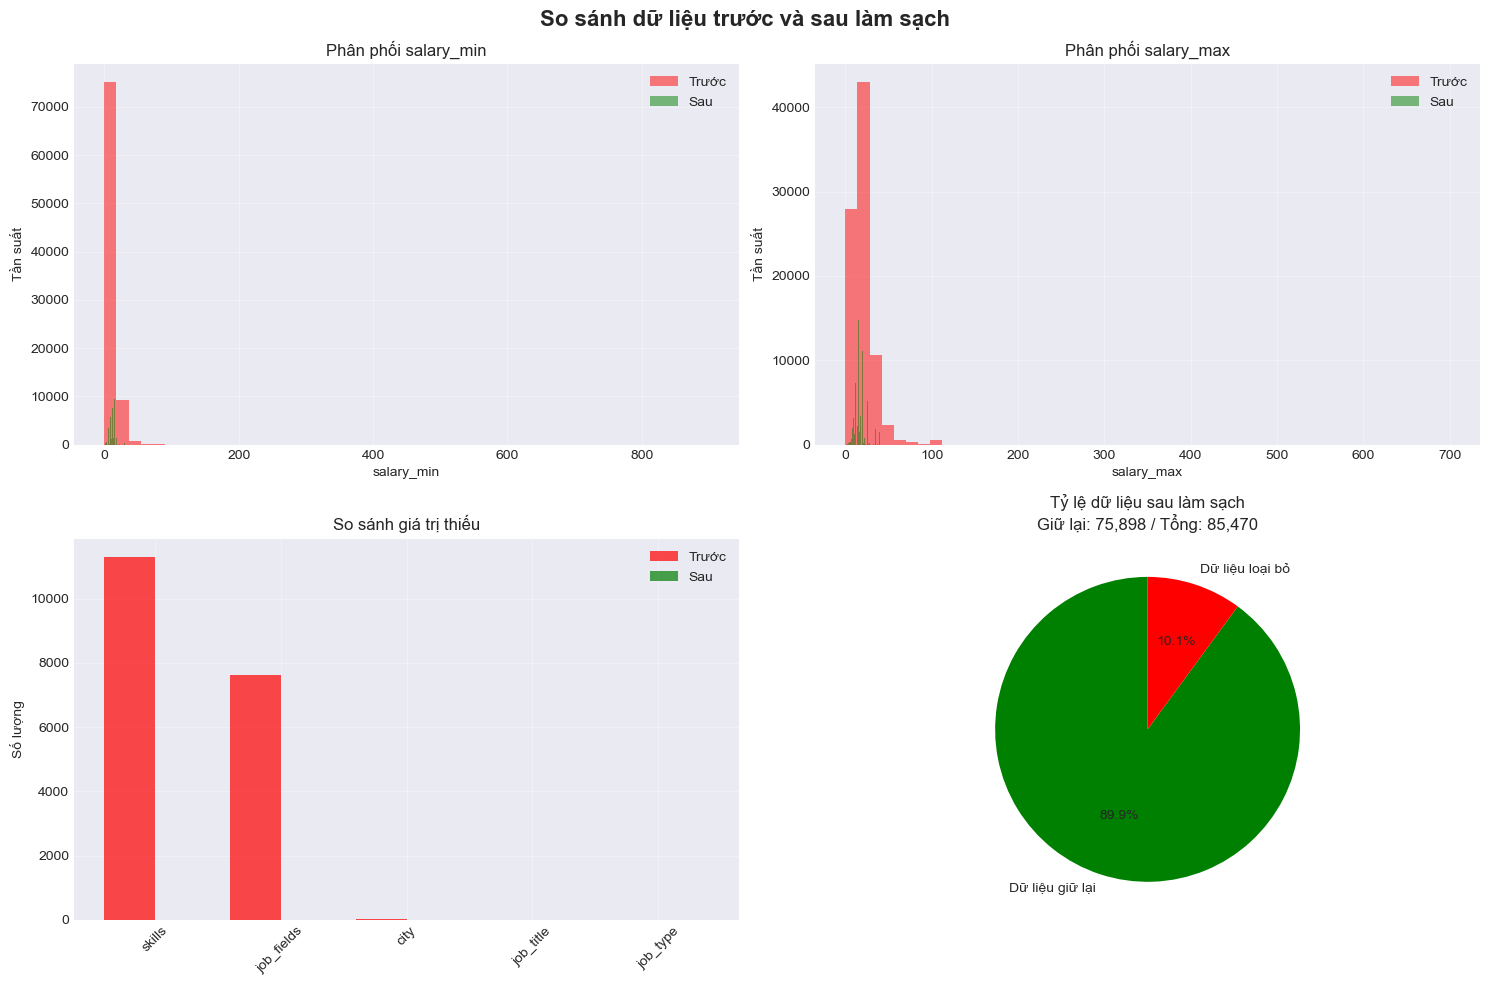


Đã lưu biểu đồ so sánh!


In [ ]:
# So sánh phân phối lương trước và sau
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('So sánh dữ liệu trước và sau làm sạch', fontsize=16, fontweight='bold')

# Salary_min
axes[0, 0].hist(df_original['salary_min'].dropna(), bins=50, alpha=0.5, label='Trước', color='red')
axes[0, 0].hist(df['salary_min'].dropna(), bins=50, alpha=0.5, label='Sau', color='green')
axes[0, 0].set_xlabel('salary_min')
axes[0, 0].set_ylabel('Tần suất')
axes[0, 0].set_title('Phân phối salary_min')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Salary_max
axes[0, 1].hist(df_original['salary_max'].dropna(), bins=50, alpha=0.5, label='Trước', color='red')
axes[0, 1].hist(df['salary_max'].dropna(), bins=50, alpha=0.5, label='Sau', color='green')
axes[0, 1].set_xlabel('salary_max')
axes[0, 1].set_ylabel('Tần suất')
axes[0, 1].set_title('Phân phối salary_max')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Missing values
missing_before = df_original.isnull().sum().sort_values(ascending=False)[:5]
missing_after = df.isnull().sum().sort_values(ascending=False)[:5]
x = range(len(missing_before))
axes[1, 0].bar([i-0.2 for i in x], missing_before.values, width=0.4, label='Trước', color='red', alpha=0.7)
axes[1, 0].bar([i+0.2 for i in x], missing_after.values, width=0.4, label='Sau', color='green', alpha=0.7)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(missing_before.index, rotation=45)
axes[1, 0].set_ylabel('Số lượng')
axes[1, 0].set_title('So sánh giá trị thiếu')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Data size
sizes_before = [len(df_original), len(df_original) - len(df)]
sizes_after = [len(df), 0]
labels = ['Dữ liệu giữ lại', 'Dữ liệu loại bỏ']
colors = ['green', 'red']
axes[1, 1].pie(sizes_before, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title(f'Tỷ lệ dữ liệu sau làm sạch\nGiữ lại: {len(df):,} / Tổng: {len(df_original):,}')

plt.tight_layout()
plt.savefig('./figures/02_before_after_cleaning.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nĐã lưu biểu đồ so sánh!")

# LƯU DỮ LIỆU ĐÃ LÀM SẠCH

In [ ]:
# Reset index
df = df.reset_index(drop=True)

# Lưu file
output_path = 'cleaned_data.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Đã lưu dữ liệu đã làm sạch vào: {output_path}")
print(f"Số dòng: {len(df):,}")
print(f"Số cột: {df.shape[1]}")

# Lưu báo cáo
cleaning_report = {
    'Số dòng ban đầu': len(df_original),
    'Số dòng sau làm sạch': len(df),
    'Số dòng đã xóa': len(df_original) - len(df),
    'Phần trăm giữ lại': f"{len(df)/len(df_original)*100:.2f}%",
    'Số giá trị thiếu ban đầu': df_original.isnull().sum().sum(),
    'Số giá trị thiếu sau xử lý': df.isnull().sum().sum(),
}

report_df = pd.DataFrame(list(cleaning_report.items()), columns=['Chỉ số', 'Giá trị'])
report_df.to_csv('../data/processed/cleaning_report.csv', index=False, encoding='utf-8-sig')
print("\nĐã lưu báo cáo làm sạch vào: cleaning_report.csv")
print("HOÀN THÀNH NOTEBOOK 02: LÀM SẠCH DỮ LIỆU!")

Đã lưu dữ liệu đã làm sạch vào: cleaned_data.csv
Số dòng: 75,898
Số cột: 11

Đã lưu báo cáo làm sạch vào: cleaning_report.csv
HOÀN THÀNH NOTEBOOK 02: LÀM SẠCH DỮ LIỆU!
